# HOMEWORK 6

In this homework you are going to use the Harris corner detector to detect the corners of a document. Document detection is a crucial task for many applications, e.g., text recognition, automatic passport reading (at airport gates), etc.

You will also have to design your own feature descriptor in order to localize and distinguish among the 4 document corners.

At the end of this notebook, there are a couple of questions for you to answer.

So let's begin, shall we?

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image we will be working on in this homework.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1bf21c1ba30>)

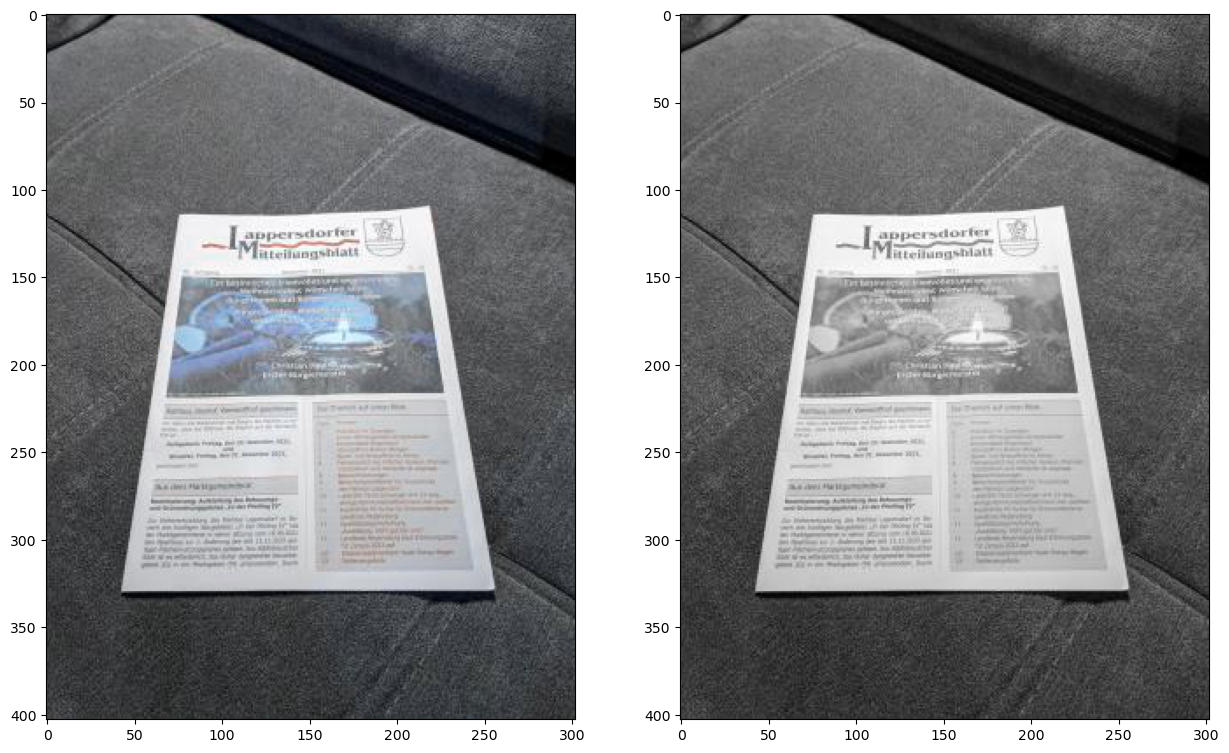

In [2]:
# Let's read the image
img = cv2.imread('document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

### Harris Corner Detector
Let us now compute Harris corners. Remember that the Harris detector computes the "cornerness" score for each image pixel.

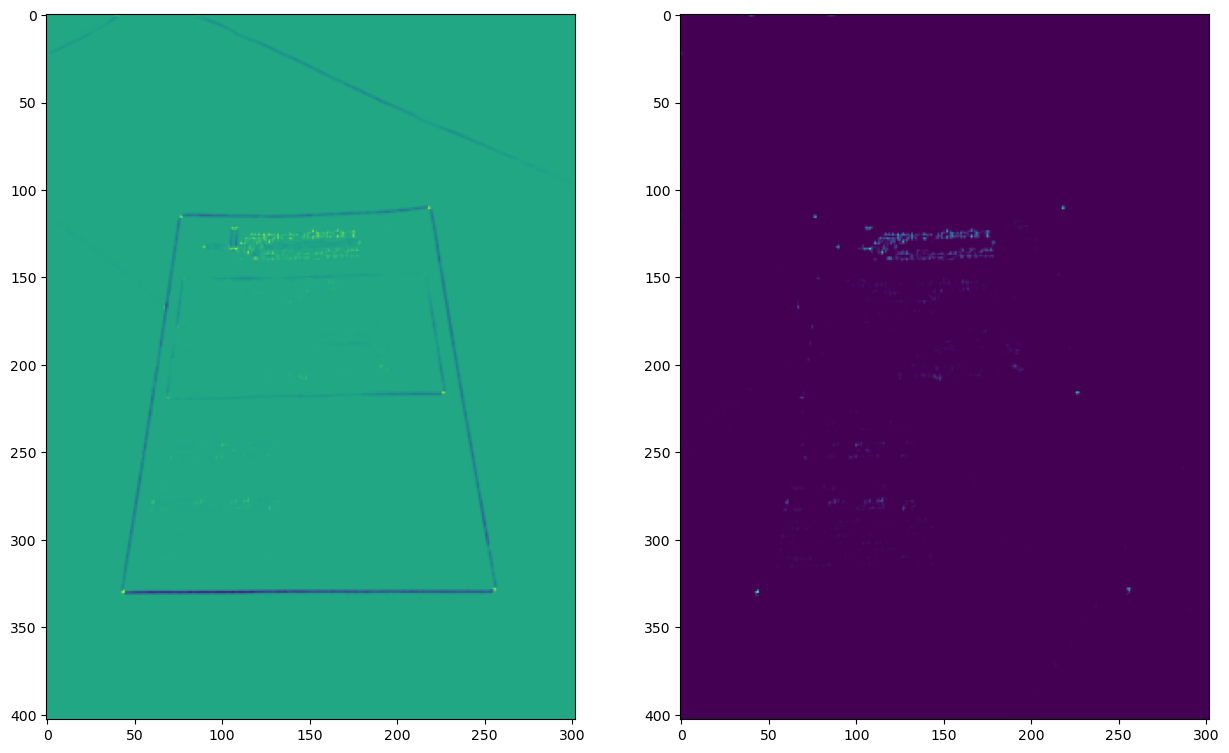

In [3]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04

from asyncio import threads


src = gray.astype(np.float32)
cornerness = cv2.cornerHarris(src, blockSize=2, ksize=3, k=0.04)
plt.subplot(121), plt.imshow(cornerness)   


rows, cols = cornerness.shape
th_edges = 0.9 * np.max(cornerness)
#th_edges = 0
th_corners = 0.9 * np.max(cornerness)
result = np.copy(img)

for r in range(rows):
    for c in range(cols):
        if cornerness[r, c] < -th_edges:
            result = cv2.circle(result, (c,r), 2, (255,0,0), -1)          #show edges in red for better visualization
        if cornerness[r, c] > th_corners:
            result = cv2.circle(result, (c,r), 2, (0,255,0), -1)          #show corners in green for better visualization

# We are not interested in edges, so put to zero all negative cornerness values
#cornerness = cornerness.clip(min=0)
cornerness[cornerness < 0]= 0

plt.subplot(122), plt.imshow(cornerness)  

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)



(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1bf233e6c10>)

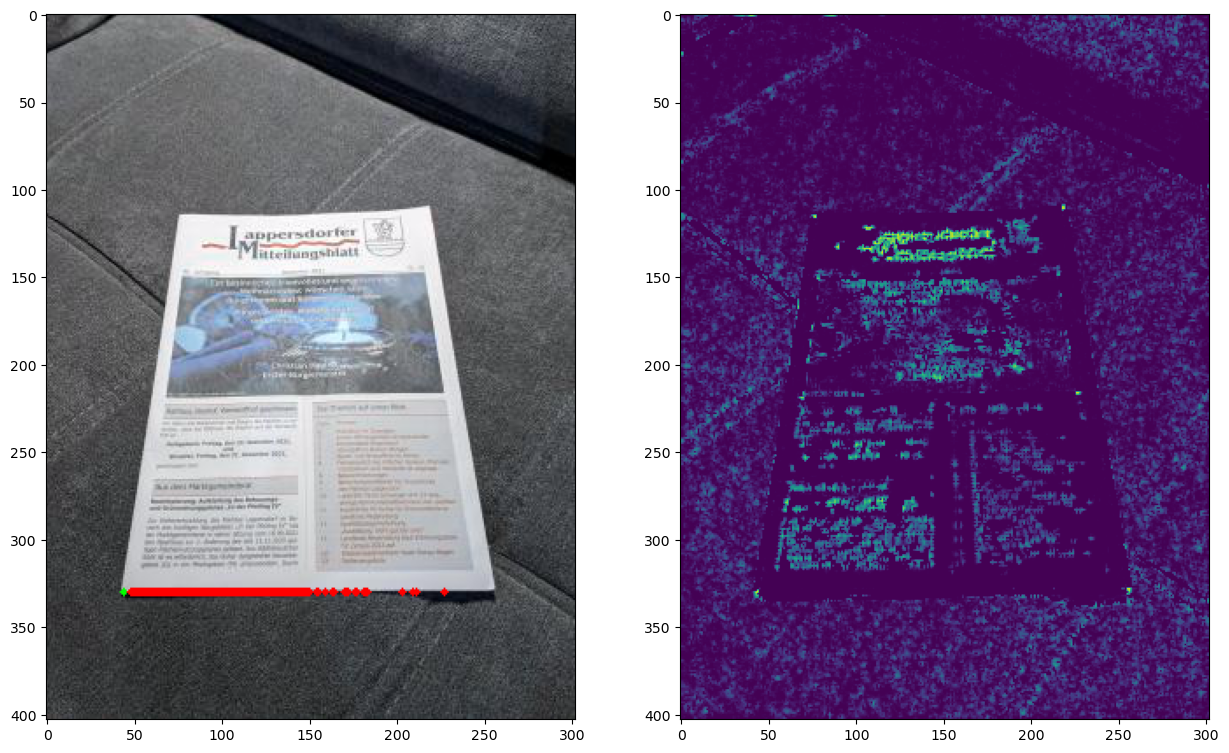

In [4]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(result)
plt.subplot(122), plt.imshow(cornerness)

At this point, you can see that the Harris detector has detected a lot of features. Not only the four document corners, but also the corners corresponding to (black) letters printed on (white) paper. How can we filter out everything but the 4 document corners?

For that purpose, let's design a custom feature descriptor suitable to detect the document corners. In order to do so, let's have a look at the top left corner.

![Top-left corner](../data/document_descriptor_example.jpg "Top-left corner")

A good descriptor of that corner, given a certain neghbouring region, would be to assess that the bottom-right quadrant is (much) brighter than the other three quadrants (i.e. top-left, top-right, bottom-left). Let's then implement it :-) I'll do the implementation for the top-left corner, you shall do the rest.

-310.9292
-310.9292
-78.81187
-78.81187


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1bf22b2fd90>)

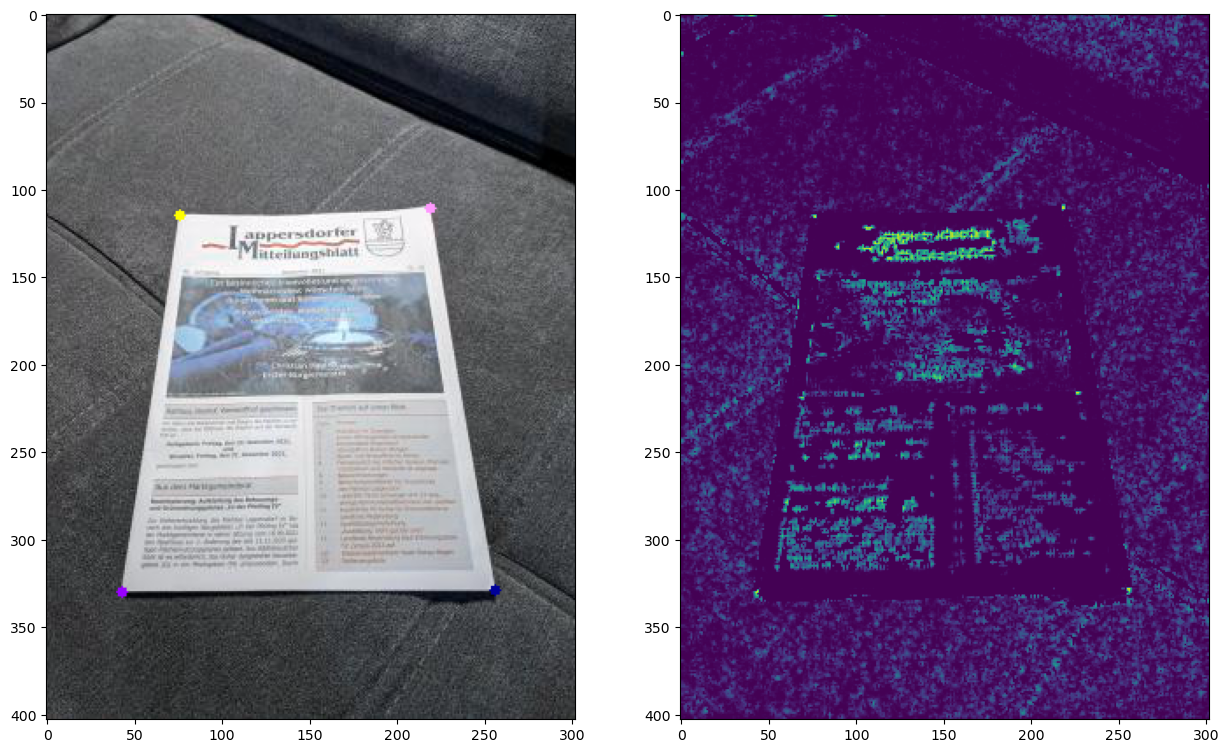

In [5]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size:quad_size*2+1]
        quad_bottom_left = block[quad_size:quad_size*2+1, 0:quad_size]
        quad_bottom_right = block[quad_size:quad_size*2+1, quad_size:quad_size*2+1]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            print(descriptor); print(th_top_left)
            # And we update the optimal location
            opt_top_left = (c, r)

          # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
        # Let's detect the best descriptor
        if descriptor > th_top_right:
            # We update the threshold
            th_top_right = descriptor
            # And we update the optimal location
            opt_top_right = (c, r)

           
        # Bottom-left corner
          # Top-right corner
        descriptor = np.mean(quad_top_right) - \
                     np.mean(quad_top_left) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        # Let's detect the best descriptor
        if descriptor > th_bottom_left:
            # We update the threshold
            th_bottom_left = descriptor
            # And we update the optimal location
            opt_bottom_left = (c, r)
            
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                     np.mean(quad_top_right) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        # Let's detect the best descriptor
        if descriptor > th_bottom_right:
            # We update the threshold
            th_bottom_right = descriptor
            # And we update the optimal location
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,255,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,153,255), -1)
out = cv2.circle(img, opt_bottom_left, 3, (153,0,255), -1)
out = cv2.circle(img, opt_bottom_right, 3, (0,0,153), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

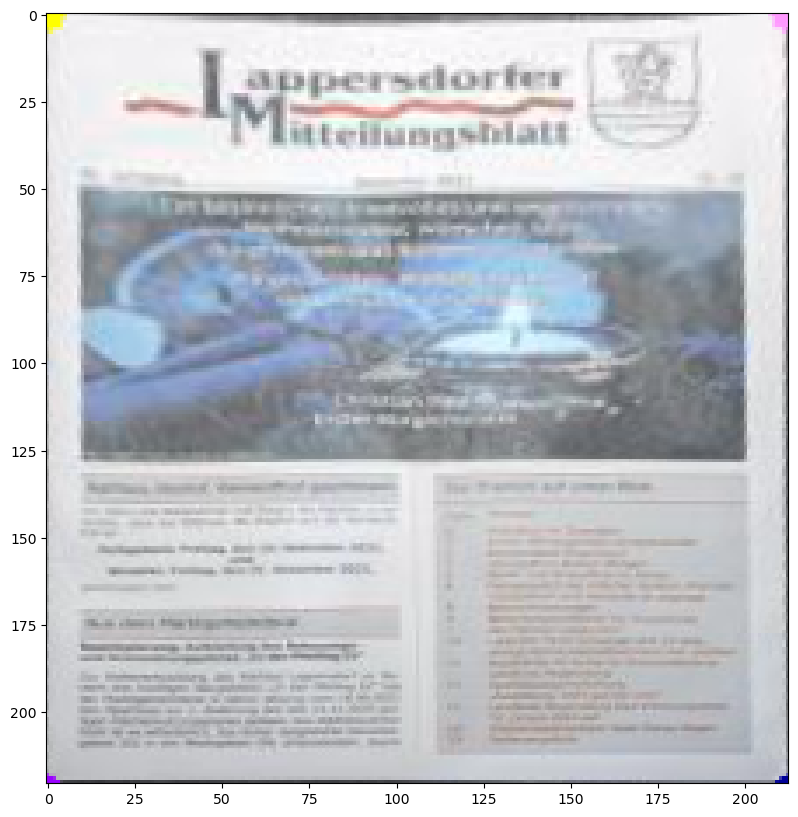

In [6]:
from operator import itemgetter
from glob import glob
import matplotlib.pyplot as plt


# Create a copy of the image
img_copy = np.copy(img)
 
pt_A = opt_top_left
pt_B = opt_bottom_left
pt_C = opt_bottom_right
pt_D = opt_top_right


width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

# Compute the perspective transform M
M = cv2.getPerspectiveTransform(input_pts,output_pts)

out = cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

plt.imshow(out)

### Questions
* Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?
* If we increased the resolution of the camera, what would you change in the current algorithm?

Answer: If we change the resolution, we should use different quadrant size.
Algorythm itself should work without changes, but we should be careful in very part of the code where we work with particular intervals of pixels.
Also we will try increasing blocksize accordingly in the cv2.cornerHarris filter.
Let's assume that our image for today homework was taken with 1mpx camera. If we would like to work with 12 megapixels per inch camera photo, 
we need to multiply our quadrant by SQRT(12) = aproximately 3.46.  

quad_size = 7*3.46 = using 24 should give us good result, however it may slow down the calculation. Why not to test if our assumptions are correct?

Let's go further and resize our image using scale 346%.

Afterwards:
### Please open Homework5_12mpx.ipynb to see the algorythm applied to the 12 mpx enlarged image.

Remember, I am **not** looking for a particular answer. I want to see how you think, so be creative ;-)

Original Dimensions :  (403, 302, 3)


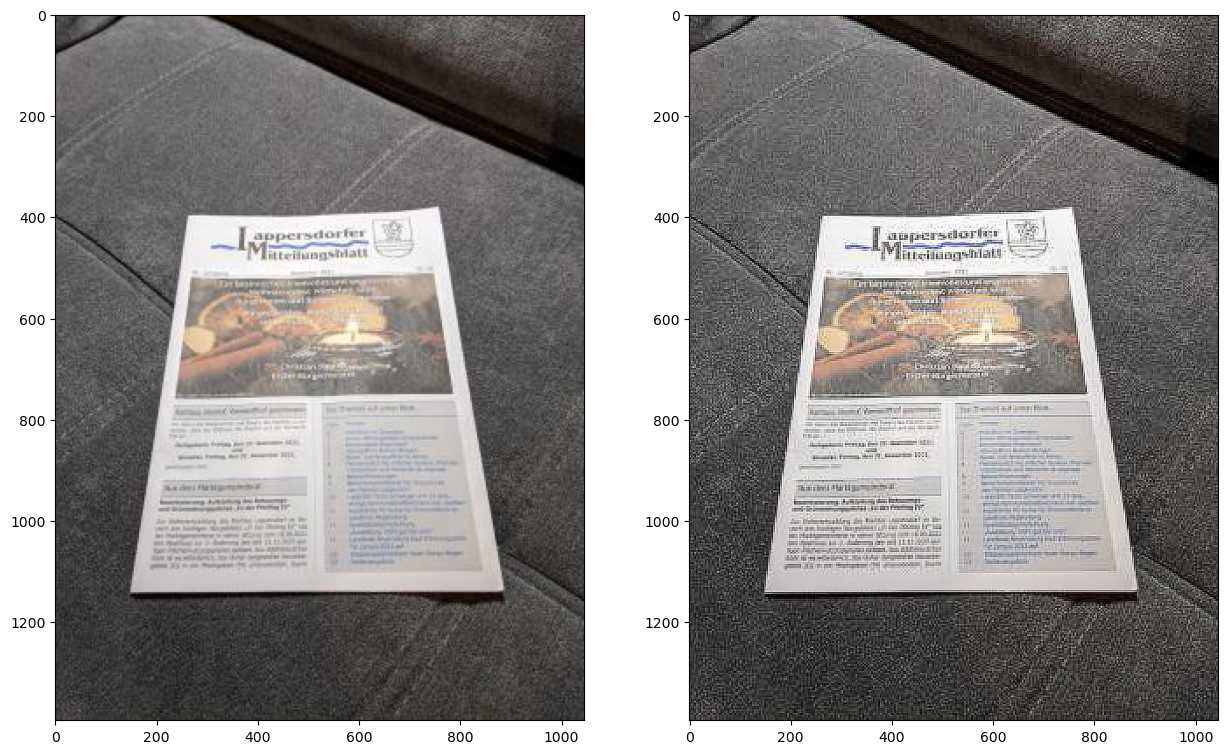

In [7]:

from PIL import Image
img = cv2.imread('document.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Original Dimensions : ',img.shape)
 
scale_percent = 346 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(resized, -1, sharpen_kernel)

plt.subplot(121), plt.imshow(resized)
plt.subplot(122), plt.imshow(sharpen)

im = Image.fromarray(resized)
im.save('document_12mpx.jpg', 'JPEG')


Please continue with Homework5_12mpx.ipynb fot the 12 mpx enlarged image